# CNN Etherium

In [172]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [173]:
df = pd.read_csv('ETH_2017-2024.csv')

df.head()

,Date,Closing Price,Volume
0,2017-11-09,320.884003,893249984
1,2017-11-10,299.252991,885985984
2,2017-11-11,314.681000,842300992
3,2017-11-12,307.907990,1613479936
4,2017-11-13,316.716003,1041889984


In [174]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = ['Closing Price', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [175]:
df.describe()

,Closing Price,Volume
count,2700.000000,2700.000000
mean,0.305957,0.138766
std,0.259907,0.117879
min,0.000000,0.000000
25%,0.041870,0.056174
50%,0.306565,0.111756
75%,0.504627,0.189933
max,1.000000,1.000000


In [176]:
df.isna().sum()

Date             0
Closing Price    0
Volume           0
dtype: int64

In [177]:
df['sequence'] = df.index + 1
df = df.drop(['Date'], axis=1)

In [178]:
df.head()

,Closing Price,Volume,sequence
0,0.050040,0.002957,1
1,0.045464,0.002878,2
2,0.048727,0.002402,3
3,0.047295,0.010800,4
4,0.049158,0.004575,5


In [179]:
df.tail()

,Closing Price,Volume,sequence
2695,0.405698,0.119474,2696
2696,0.383096,0.190988,2697
2697,0.368675,0.126024,2698
2698,0.364211,0.100544,2699
2699,0.367862,0.164903,2700


In [180]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

closing_price = df['Closing Price'].values
volume = df['Volume'].values

closing_price_windows = sliding_window_view(closing_price, window_shape=timestep_size)
volume_windows = sliding_window_view(volume, window_shape=timestep_size)

X = np.vstack((closing_price_windows, volume_windows))

y = np.array([0] * len(closing_price_windows) + [1] * len(volume_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (5302, 50)
y: (5302,)


In [181]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

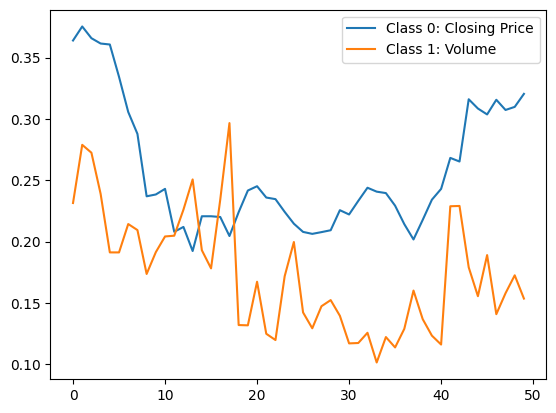

In [182]:
test_signal_index = 166

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: Closing Price")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: Volume")
plt.legend()

In [183]:
train_size = 0.7
splitter = int(len(X) * train_size)

x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [184]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

3711
1591
3711
1591


In [185]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [186]:
x_train

array([[[0.1944704 ],
        [0.15727508],
        [0.12843408],
        ...,
        [0.11954767],
        [0.12192808],
        [0.15308146]],

       [[0.22010279],
        [0.2409451 ],
        [0.18851274],
        ...,
        [0.11516173],
        [0.1176349 ],
        [0.18161177]],

       [[0.20819622],
        [0.48543882],
        [0.61334135],
        ...,
        [0.30092151],
        [0.27928316],
        [0.37105176]],

       ...,

       [[0.14433524],
        [0.13213037],
        [0.19999049],
        ...,
        [0.15881623],
        [0.17650534],
        [0.16755668]],

       [[0.53006946],
        [0.53169972],
        [0.56691044],
        ...,
        [0.61270713],
        [0.62313998],
        [0.64174655]],

       [[0.11807651],
        [0.13195408],
        [0.11233768],
        ...,
        [0.10856127],
        [0.09352609],
        [0.09496546]]])

In [187]:
class_names = np.array(['Closing Price', 'Volume'])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            keras.layers.Input(input_shape),


            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),


            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            keras.layers.Dense(64, activation="relu"),

            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])


model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 50, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,802 (18.76 KB)

 Trainable params: 4,674 (18.26 KB)

 Non-trainable params: 128 (512.00 B)

In [188]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5516 - sparse_categorical_accuracy: 0.7025 - val_loss: 0.6459 - val_sparse_categorical_accuracy: 0.7120
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4189 - sparse_categorical_accuracy: 0.7827 - val_loss: 0.5962 - val_sparse_categorical_accuracy: 0.7402
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8386 - val_loss: 0.5603 - val_sparse_categorical_accuracy: 0.6945
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2765 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.7295
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.5542 - val_sparse_categorical_accuracy: 0.7429
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.6903 - val_sparse_categorical_accuracy: 0.7456
Epoch 7/50

<Axes: >

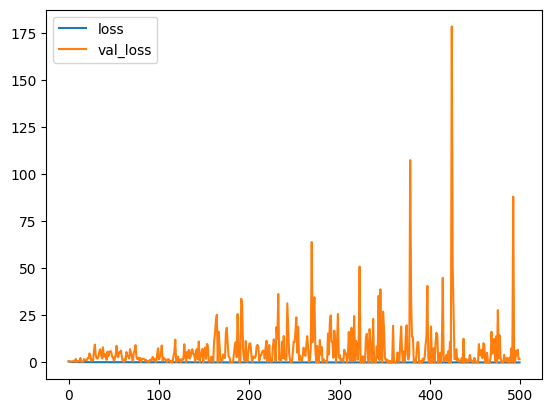

In [189]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

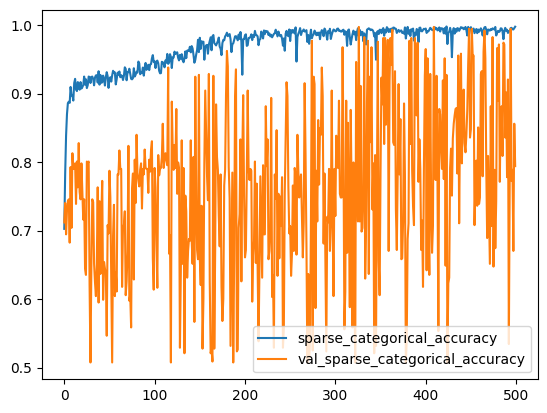

In [190]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
# The val_loss is not very stable. I used EarlyStopping and ReduceLROnPlateau to improve training stability but
# even though the stability improved, the results of the model were significantly worse.

In [191]:
model = keras.models.load_model("best_model2.keras")

In [192]:
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.008890071883797646, 0.997485876083374]

Train data evaluation:
[0.010056249797344208, 0.9970358610153198]


In [193]:
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Axes: >

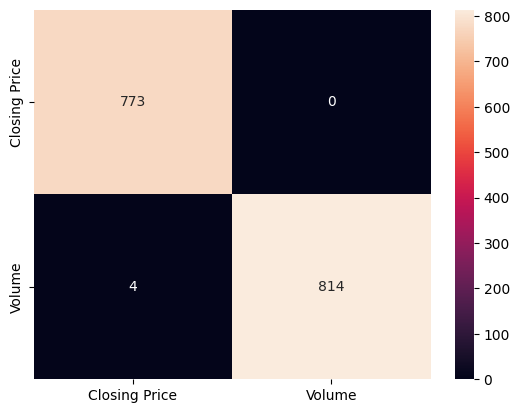

In [194]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names)

In [195]:
print(classification_report(y_test, test_predictions, target_names=class_names))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

               precision    recall  f1-score   support

Closing Price       0.99      1.00      1.00       773
       Volume       1.00      1.00      1.00       818

     accuracy                           1.00      1591
    macro avg       1.00      1.00      1.00      1591
 weighted avg       1.00      1.00      1.00      1591


Model overall accuracy: 99.75%


In [196]:
# roc-auc score = 1 means that 
roc_auc_score(y_test, model.predict(x_test)[:,1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


1.0

In [197]:
# Code for generating synthetic test data was generated with AI

synthetic_price = np.random.normal(0, 1, 50)
synthetic_volume = np.random.normal(0, 1, 50)
synthetic_sample = np.vstack([synthetic_price, synthetic_volume]).T
synthetic_sample = synthetic_sample.reshape(1, synthetic_sample.shape[0], synthetic_sample.shape[1])


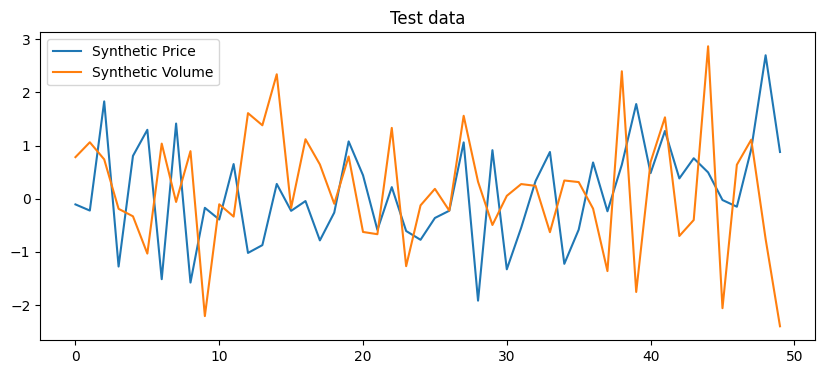

In [198]:
# Plot shows that the synthetic data is random
# There is no pattern or trend in the data

plt.figure(figsize=(10,4))
plt.plot(synthetic_price, label='Synthetic Price')
plt.plot(synthetic_volume, label='Synthetic Volume')
plt.legend()
plt.title('Test data')
plt.show()


In [199]:
# The models prediction for the synthetic input is Class 1 (Volume)
# In theory, since the data is random, the model should have no strong preference for either class
# My assumption, why the model picked Class 1 is, that the volume data might be more random than the price data


synthetic_pred = model.predict(synthetic_sample)
predicted_class = np.argmax(synthetic_pred, axis=-1)
print(f"Predicted Class: {predicted_class}")
print(f"Output: {synthetic_pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Class: [1]
Output: [[0. 1.]]
